# CMP466 Machine Learning Project - Stock Investment Classification
**Group 7 - Summer 2025**

Binary classification system for stock investment opportunities using technical indicators and ML algorithms (KNN, Logistic Regression, SVM, Decision Trees, Ensemble Methods).

#Problem Understanding and Solution Approach

**Problem**: Automated stock investment classification system needed to reduce subjective bias.

**Solution**: Binary classification (Good Investment=1, Bad Investment=0) using weighted scoring:
- Price Momentum (30%): >5% gain over 30 days
- Technical Position (25%): Price vs moving averages
- Risk Assessment (20%): Volatility levels
- Market Sentiment (15%): RSI values (30-70 range)
- Liquidity Factor (10%): Trading volume above average

**Threshold**: Score ≥ 0.6 indicates good investment opportunity.

In [30]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA

# Data Loading and Exploration

In [31]:
import pandas as pd

# Load data
df = pd.read_csv('Dataset/top_10_stock_data.csv')

# Parse dates and sort
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['Ticker', 'Date']).reset_index(drop=True)

# Basic info
print("Dataset shape:", df.shape)
print("Companies:", df['Ticker'].unique())
print("Date range:", df['Date'].min(), "to", df['Date'].max())
print("Trading days:", df['Date'].nunique())

# Records per company
print("\nRecords per company:")
print(df.groupby('Ticker').size().describe())

# Missing data check
print("\nMissing values per column:")
print(df.isnull().sum())
print("Total missing:", df.isnull().sum().sum())

# Data types
print("\nColumn types:")
print(df.dtypes)

# Stats summary
print("\nSummary stats:")
print(df.describe())


Dataset shape: (25486, 8)
Companies: ['2222.SR' 'AAPL' 'AMZN' 'BRK-B' 'GOOG' 'GOOGL' 'LLY' 'META' 'MSFT' 'NVDA'
 'TSM']
Date range: 2015-01-02 00:00:00 to 2024-08-29 00:00:00
Trading days: 2700

Records per company:
count      11.000000
mean     2316.909091
std       378.396737
min      1176.000000
25%      2431.000000
50%      2431.000000
75%      2431.000000
max      2431.000000
dtype: float64

Missing values per column:
Date         0
Ticker       0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Total missing: 0

Column types:
Date         datetime64[ns]
Ticker               object
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

Summary stats:
                                Date          Open          High  \
count                          25486  25486.000000  25486.000000   
mean   2019-12-11 

# Feature Engineering

**Technical Indicators Created:**
- **Daily Returns**: Price change percentage
- **Moving Averages**: MA20 (short-term), MA50 (medium-term)
- **RSI**: 14-period momentum indicator
- **Volatility**: 20-period standard deviation
- **Volume Ratio**: Current vs average volume
- **Momentum**: 30-day price momentum
- **Binary Signals**: Price above MA20/MA50

In [32]:
# Feature Engineering
def create_features(df):
    df_features = df.copy()
    features = []
    
    for ticker in df_features['Ticker'].unique():
        ticker_data = df_features[df_features['Ticker'] == ticker].copy()
        
        # Technical indicators
        ticker_data['Daily_Return'] = ticker_data['Close'].pct_change()
        ticker_data['MA_20'] = ticker_data['Close'].rolling(window=20).mean()
        ticker_data['MA_50'] = ticker_data['Close'].rolling(window=50).mean()
        ticker_data['RSI'] = calculate_rsi(ticker_data['Close'])
        ticker_data['Volatility'] = ticker_data['Daily_Return'].rolling(window=20).std()
        ticker_data['Volume_Ratio'] = ticker_data['Volume'] / ticker_data['Volume'].rolling(window=20).mean()
        ticker_data['Momentum_30d'] = ticker_data['Close'] / ticker_data['Close'].shift(30) - 1
        ticker_data['Price_above_MA20'] = (ticker_data['Close'] > ticker_data['MA_20']).astype(int)
        ticker_data['Price_above_MA50'] = (ticker_data['Close'] > ticker_data['MA_50']).astype(int)
        
        features.append(ticker_data)
    
    return pd.concat(features, ignore_index=True)

def calculate_rsi(prices, window=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df_features = create_features(df)
print(f"Features Created: {df_features.shape[1] - df.shape[1]}")

Features Created: 9


# Target Variable Creation

**Investment Scoring System** (Weighted):
- **Positive Momentum (30%)**: >5% gain in 30 days
- **Technical Strength (25%)**: Price above moving averages
- **Stability (20%)**: Low volatility (bottom 30% range)
- **Market Health (15%)**: RSI between 30-70
- **Volume Activity (10%)**: Volume >120% of average

**Final Classification**: Score ≥ 0.6 = Good Investment

In [33]:
# Create Target Variable
def create_target(df):
    df_target = df.copy()
    df_target['Good_Investment'] = 0
    
    for ticker in df_target['Ticker'].unique():
        ticker_mask = df_target['Ticker'] == ticker
        ticker_data = df_target[ticker_mask].copy()
        
        if len(ticker_data) < 50:
            continue # to Skip companies with fewer than 50 records (not enough data for fair scoring).
            
        # Investment scoring
        investment_score = 0
        investment_score += (ticker_data['Momentum_30d'] > 0.05).astype(int) * 0.3
        investment_score += (ticker_data['Price_above_MA20'] + ticker_data['Price_above_MA50']) / 2 * 0.25
        investment_score += (ticker_data['Volatility'] < ticker_data['Volatility'].quantile(0.3)).astype(int) * 0.2
        investment_score += ((ticker_data['RSI'] > 30) & (ticker_data['RSI'] < 70)).astype(int) * 0.15
        investment_score += (ticker_data['Volume_Ratio'] > 1.2).astype(int) * 0.1
        
        df_target.loc[ticker_mask, 'Good_Investment'] = (investment_score >= 0.6).astype(int)
    
    return df_target

df_final = create_target(df_features)
df_final = df_final.dropna()

print(f"Target Distribution: {df_final['Good_Investment'].value_counts().to_dict()}")
print(f"Good Investment Rate: {df_final['Good_Investment'].mean():.2%}")

Target Distribution: {0: 16093, 1: 8854}
Good Investment Rate: 35.49%


#  Data Preprocessing

In [34]:
# Data Preprocessing

feature_cols = [
    'Daily_Return', 'MA_20', 'MA_50', 'RSI', 'Volatility',
    'Volume_Ratio', 'Momentum_30d', 'Price_above_MA20', 'Price_above_MA50'
]

X = df_final[feature_cols].copy()
y = df_final['Good_Investment'].copy()

print(f"Features shape: {X.shape}")
print("Target distribution:", y.value_counts().to_dict())

# Missing Value Analysis
print("\n-- Missing Values --")
missing_summary = pd.DataFrame({
    'Column': X.columns,
    'Missing_Count': X.isnull().sum(),
    'Missing_%': (X.isnull().sum() / len(X)) * 100
})
print(missing_summary)

if X.isnull().sum().sum() == 0:
    print("No missing values.")
else:
    print("Total missing values:", X.isnull().sum().sum())

# Infinite Value Analysis
print("\n-- Infinite Values --")
inf_counts = {}
for col in X.columns:
    inf_count = np.isinf(X[col]).sum()
    inf_counts[col] = inf_count
    if inf_count > 0:
        print(f"{col}: {inf_count}")

total_inf = sum(inf_counts.values())
if total_inf > 0:
    print(f"Total infinite values: {total_inf}")
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.fillna(X.median())
    print("Replaced infs with median values.")
else:
    print("No infinite values found.")

# Final Data Quality Check
print("\n-- Final Data Quality --")
print("Missing values left:", X.isnull().sum().sum())
print("Infinite values left:", np.isinf(X.select_dtypes(include=[np.number])).sum().sum())

# Train/Test Split
print("\n-- Train/Test Split --")
split_point = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

print(f"Train samples: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Test samples: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")
print("Train target dist:", y_train.value_counts().to_dict())
print("Test target dist:", y_test.value_counts().to_dict())

# Feature Scaling - Standardization
print("\n-- Scaling --")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols)

print("Scaling done.")
print(f"Train mean: {X_train_scaled.mean().mean():.6f}")
print(f"Train std: {X_train_scaled.std().mean():.6f}")
print("Shapes - Train:", X_train_scaled.shape, ", Test:", X_test_scaled.shape)


Features shape: (24947, 9)
Target distribution: {0: 16093, 1: 8854}

-- Missing Values --
                            Column  Missing_Count  Missing_%
Daily_Return          Daily_Return              0        0.0
MA_20                        MA_20              0        0.0
MA_50                        MA_50              0        0.0
RSI                            RSI              0        0.0
Volatility              Volatility              0        0.0
Volume_Ratio          Volume_Ratio              0        0.0
Momentum_30d          Momentum_30d              0        0.0
Price_above_MA20  Price_above_MA20              0        0.0
Price_above_MA50  Price_above_MA50              0        0.0
No missing values.

-- Infinite Values --
No infinite values found.

-- Final Data Quality --
Missing values left: 0
Infinite values left: 0

-- Train/Test Split --
Train samples: 19957 (80.0%)
Test samples: 4990 (20.0%)
Train target dist: {0: 13196, 1: 6761}
Test target dist: {0: 2897, 1: 2093}

--

# Machine Learning Methods

    **K-Nearest Neighbors (KNN)**
    
**Approach**: Instance-based learning using similarity measures
**Optimization**: k values [3, 5, 7, 9, 11, 15], Euclidean distance
**Rationale**: Captures local patterns in financial data

KNN HYPERPARAMETER OPTIMIZATION
k=3: F1=0.8888855503535975 (+/- 0.04389716762231989)
k=5: F1=0.8954639954339034 (+/- 0.04521656139719818)
k=7: F1=0.8965592384636798 (+/- 0.04618353278022173)
k=9: F1=0.8963756848969823 (+/- 0.04842072020430804)
k=11: F1=0.8955203524542702 (+/- 0.048139169554149264)
k=15: F1=0.8958373106841275 (+/- 0.04726347389544102)

Best k value: 7
Best CV F1-score: 0.8965592384636798

KNN FINAL PERFORMANCE (k=7):
Accuracy: 0.8685
Precision: 0.8772
Recall: 0.8685
F1-Score: 0.8655
AUC: 0.9334
Type I Error (FPR): 0.0376
Type II Error (FNR): 0.2613

=== ERROR ANALYSIS ===
Confusion Matrix:
True Negatives (TN): 2788
False Positives (FP): 109
False Negatives (FN): 547
True Positives (TP): 1546

Type I Error (False Positive Rate): 0.0376
  - Probability of classifying a bad investment as good
Type II Error (False Negative Rate): 0.2613
  - Probability of classifying a good investment as bad


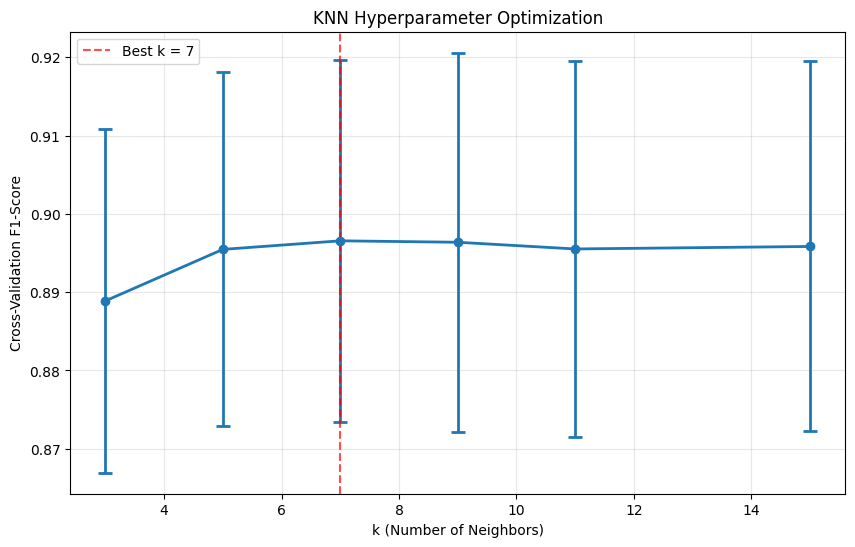

In [35]:
# KNN Hyperparameter Optimization
from sklearn.model_selection import cross_val_score

print("KNN HYPERPARAMETER OPTIMIZATION")

# Testing different k values
k_values = [3, 5, 7, 9, 11, 15]
knn_results = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean', weights='uniform')
    # Use cross-validation on training set
    cv_scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='f1_weighted')
    avg_score = cv_scores.mean()
    std_score = cv_scores.std()
    
    knn_results.append({
        'k': k,
        'CV_F1_Mean': avg_score,
        'CV_F1_Std': std_score
    })
    print(f"k={k}: F1={avg_score} (+/- {std_score*2})")

# Convert to DataFrame for analysis
knn_df = pd.DataFrame(knn_results)
best_k = knn_df.loc[knn_df['CV_F1_Mean'].idxmax(), 'k']

print(f"\nBest k value: {best_k}")
print(f"Best CV F1-score: {knn_df['CV_F1_Mean'].max()}")

# Train final KNN model with best k
knn_final = KNeighborsClassifier(n_neighbors=int(best_k), metric='euclidean', weights='uniform')
knn_final.fit(X_train_scaled, y_train)

# Make predictions
knn_pred = knn_final.predict(X_test_scaled)
knn_proba = knn_final.predict_proba(X_test_scaled)[:, 1]


knn_cm = confusion_matrix(y_test, knn_pred)
tn, fp, fn, tp = knn_cm.ravel()

type_1_error = fp / (fp + tn)  # FPR
type_2_error = fn / (fn + tp)  # FNR

knn_metrics = {
    'Accuracy': accuracy_score(y_test, knn_pred),
    'Precision': precision_score(y_test, knn_pred, average='weighted'),
    'Recall': recall_score(y_test, knn_pred, average='weighted'),
    'F1-Score': f1_score(y_test, knn_pred, average='weighted'),
    'AUC': roc_auc_score(y_test, knn_proba),
    'Type I Error (FPR)': type_1_error,
    'Type II Error (FNR)': type_2_error
}

print(f"\nKNN FINAL PERFORMANCE (k={best_k}):")
for metric, value in knn_metrics.items():
    print(f"{metric}: {value:.4f}")

# Detailed error analysis
print(f"\n=== ERROR ANALYSIS ===")
print(f"Confusion Matrix:")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")
print(f"\nType I Error (False Positive Rate): {type_1_error:.4f}")
print(f"  - Probability of classifying a bad investment as good")
print(f"Type II Error (False Negative Rate): {type_2_error:.4f}")
print(f"  - Probability of classifying a good investment as bad")

# Visualize k optimization
plt.figure(figsize=(10, 6))
plt.errorbar(knn_df['k'], knn_df['CV_F1_Mean'], yerr=knn_df['CV_F1_Std'], 
             marker='o', capsize=5, capthick=2, linewidth=2)
plt.axvline(x=best_k, color='red', linestyle='--', alpha=0.7, label=f'Best k = {best_k}')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Cross-Validation F1-Score')
plt.title('KNN Hyperparameter Optimization')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


trained_models = {}
predictions = {}
probabilities = {}

KNN ANALYSIS:
Confusion Matrix:
[[2788  109]
 [ 547 1546]]

Classification Report:
                 precision    recall  f1-score   support

 Bad Investment       0.84      0.96      0.89      2897
Good Investment       0.93      0.74      0.82      2093

       accuracy                           0.87      4990
      macro avg       0.89      0.85      0.86      4990
   weighted avg       0.88      0.87      0.87      4990



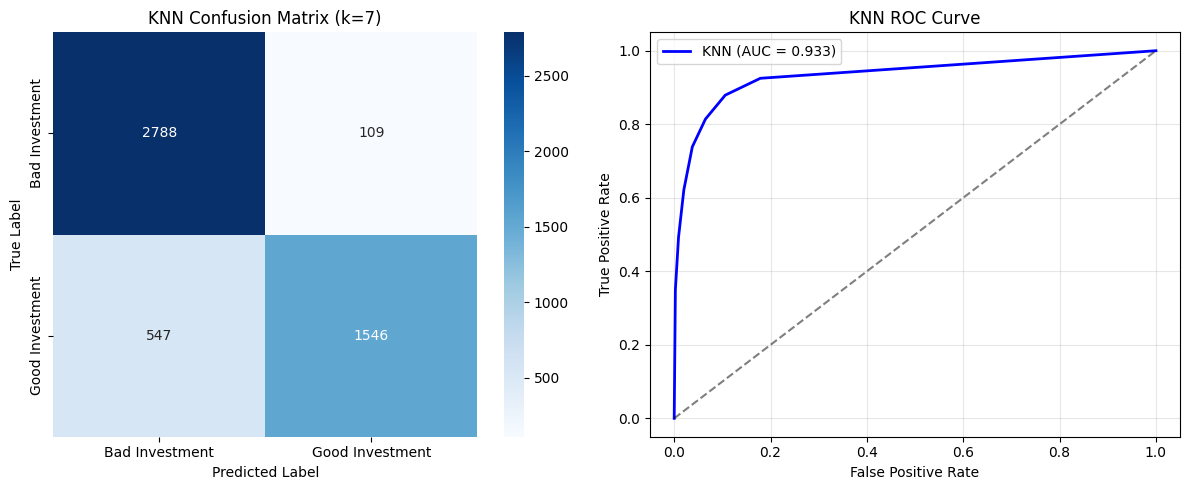

KNN Final Performance: Accuracy=0.869, F1=0.865


In [36]:
# KNN Visualizations
print("KNN ANALYSIS:")

# Confusion Matrix
cm_knn = confusion_matrix(y_test, knn_pred)
print(f"Confusion Matrix:")
print(cm_knn)


print(f"\nClassification Report:")
print(classification_report(y_test, knn_pred, target_names=['Bad Investment', 'Good Investment']))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Confusion Matrix
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Bad Investment', 'Good Investment'],
            yticklabels=['Bad Investment', 'Good Investment'])
axes[0].set_title(f'KNN Confusion Matrix (k={best_k})')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# ROC Curve
fpr_knn, tpr_knn, _ = roc_curve(y_test, knn_proba)
axes[1].plot(fpr_knn, tpr_knn, color='blue', linewidth=2, 
             label=f'KNN (AUC = {knn_metrics["AUC"]:.3f})')
axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('KNN ROC Curve')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"KNN Final Performance: Accuracy={knn_metrics['Accuracy']:.3f}, F1={knn_metrics['F1-Score']:.3f}")

## Logistic Regression
**Approach**: Linear probabilistic classification using sigmoid function
**Optimization**: C values [0.01, 0.1, 1.0, 10.0, 100.0] with L2 regularization
**Advantage**: Interpretable coefficients showing feature importance

LOGISTIC REGRESSION HYPERPARAMETER OPTIMIZATION:
C=0.01: F1=0.8640 (+/- 0.0247)
C=0.1: F1=0.8622 (+/- 0.0231)
C=1.0: F1=0.8621 (+/- 0.0231)
C=10.0: F1=0.8624 (+/- 0.0217)
C=100.0: F1=0.8623 (+/- 0.0218)

Best C value: 0.01
Best CV F1-score: 0.8640

LOGISTIC REGRESSION FINAL PERFORMANCE (C=0.01)
Accuracy: 0.8421
Precision: 0.8432
Recall: 0.8421
F1-Score: 0.8402
AUC: 0.9253


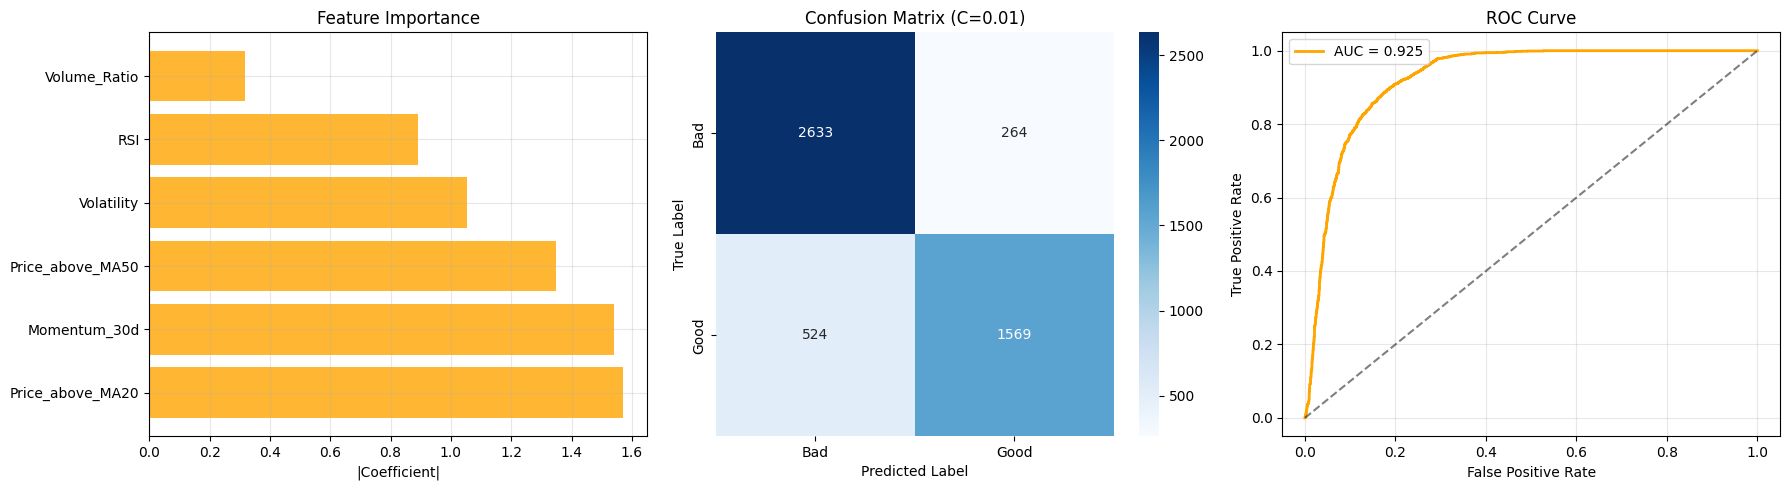

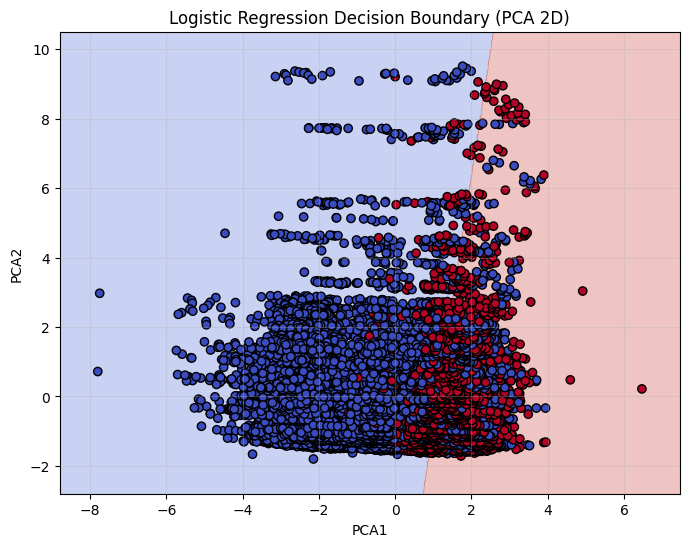

In [37]:
# Logistic Regression Hyperparameter Optimization
print("LOGISTIC REGRESSION HYPERPARAMETER OPTIMIZATION:")

# Test different C values (regularization strength)
C_values = [0.01, 0.1, 1.0, 10.0, 100.0]
lr_results = []

for C in C_values:
    lr = LogisticRegression(C=C, random_state=42, max_iter=1000)
    cv_scores = cross_val_score(lr, X_train_scaled, y_train, cv=5, scoring='f1_weighted')
    avg_score = cv_scores.mean()
    std_score = cv_scores.std()
    
    lr_results.append({
        'C': C,
        'CV_F1_Mean': avg_score,
        'CV_F1_Std': std_score
    })
    print(f"C={C}: F1={avg_score:.4f} (+/- {std_score*2:.4f})")

# Convert to DataFrame and find best C
lr_df = pd.DataFrame(lr_results)
best_C = lr_df.loc[lr_df['CV_F1_Mean'].idxmax(), 'C']

print(f"\nBest C value: {best_C}")
print(f"Best CV F1-score: {lr_df['CV_F1_Mean'].max():.4f}")

# Train final Logistic Regression model
lr_final = LogisticRegression(C=best_C, random_state=42, max_iter=1000)
lr_final.fit(X_train_scaled, y_train)

# Make predictions
lr_pred = lr_final.predict(X_test_scaled)
lr_proba = lr_final.predict_proba(X_test_scaled)[:, 1]

# Evaluation
lr_metrics = {
    'Accuracy': accuracy_score(y_test, lr_pred),
    'Precision': precision_score(y_test, lr_pred, average='weighted'),
    'Recall': recall_score(y_test, lr_pred, average='weighted'),
    'F1-Score': f1_score(y_test, lr_pred, average='weighted'),
    'AUC': roc_auc_score(y_test, lr_proba)
}

print(f"\nLOGISTIC REGRESSION FINAL PERFORMANCE (C={best_C})")
for metric, value in lr_metrics.items():
    print(f"{metric}: {value:.4f}")

# Feature Importance (Coefficients)
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': lr_final.coef_[0],
    'Abs_Coefficient': np.abs(lr_final.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

# Logistic Regression Visualizations
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Feature Importance
top_features = feature_importance.head(6)
axes[0].barh(range(len(top_features)), top_features['Abs_Coefficient'], color='orange', alpha=0.8)
axes[0].set_yticks(range(len(top_features)))
axes[0].set_yticklabels(top_features['Feature'])
axes[0].set_xlabel('|Coefficient|')
axes[0].set_title('Feature Importance')
axes[0].grid(True, alpha=0.3)

# Confusion Matrix
cm_lr = confusion_matrix(y_test, lr_pred)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['Bad', 'Good'], yticklabels=['Bad', 'Good'])
axes[1].set_title(f'Confusion Matrix (C={best_C})')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

# ROC Curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_proba)
axes[2].plot(fpr_lr, tpr_lr, color='orange', linewidth=2, 
             label=f'AUC = {lr_metrics["AUC"]:.3f}')
axes[2].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[2].set_xlabel('False Positive Rate')
axes[2].set_ylabel('True Positive Rate')
axes[2].set_title('ROC Curve')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# decision boundary plot--

from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

pca = PCA(n_components=2)
X_vis = pca.fit_transform(X_train_scaled)
lr_vis = LogisticRegression(C=best_C, random_state=42, max_iter=1000)
lr_vis.fit(X_vis, y_train)
h = 0.02
x_min, x_max = X_vis[:, 0].min() - 1, X_vis[:, 0].max() + 1
y_min, y_max = X_vis[:, 1].min() - 1, X_vis[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = lr_vis.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
plt.scatter(X_vis[:, 0], X_vis[:, 1], c=y_train, edgecolors='k', cmap='coolwarm')
plt.title("Logistic Regression Decision Boundary (PCA 2D)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.grid(True, alpha=0.3)
plt.show()



---

## Support Vector Machine (SVM)

### Algorithm Overview:
SVM finds the optimal hyperplane that maximizes the margin between classes using support vectors (boundary points). The kernel trick enables non-linear classification by mapping data to higher dimensions.

### Implementation Approach:
- **Kernels**: Linear and RBF (gamma='scale') only
- **Regularization**: C values [0.1, 1.0, 10.0] 
- **Evaluation**: 3-fold cross-validation with F1-weighted scoring
- **Selection**: Best configuration based on highest F1 score

### Key Parameters:
- **C**: Controls margin vs training error trade-off
- **Kernel**: Linear (simple) vs RBF (non-linear patterns)
- **Gamma**: RBF kernel complexity parameter (fixed at 'scale')

Evaluating SVM configurations:

Kernel: linear
  C=0.1 -> F1=0.8575 (+/- 0.0084)
  C=1.0 -> F1=0.8588 (+/- 0.0046)
  C=10.0 -> F1=0.8599 (+/- 0.0027)

Kernel: rbf
  C=0.1 -> F1=0.8782 (+/- 0.0068)
  C=1.0 -> F1=0.8978 (+/- 0.0103)
  C=10.0 -> F1=0.9067 (+/- 0.0046)

Best configuration:
Kernel = rbf, C = 10.0, F1 = 0.9067

Test set performance:
Accuracy:  0.8770
Precision: 0.8867
Recall:    0.8770
F1-Score:  0.8740
AUC:       0.9579


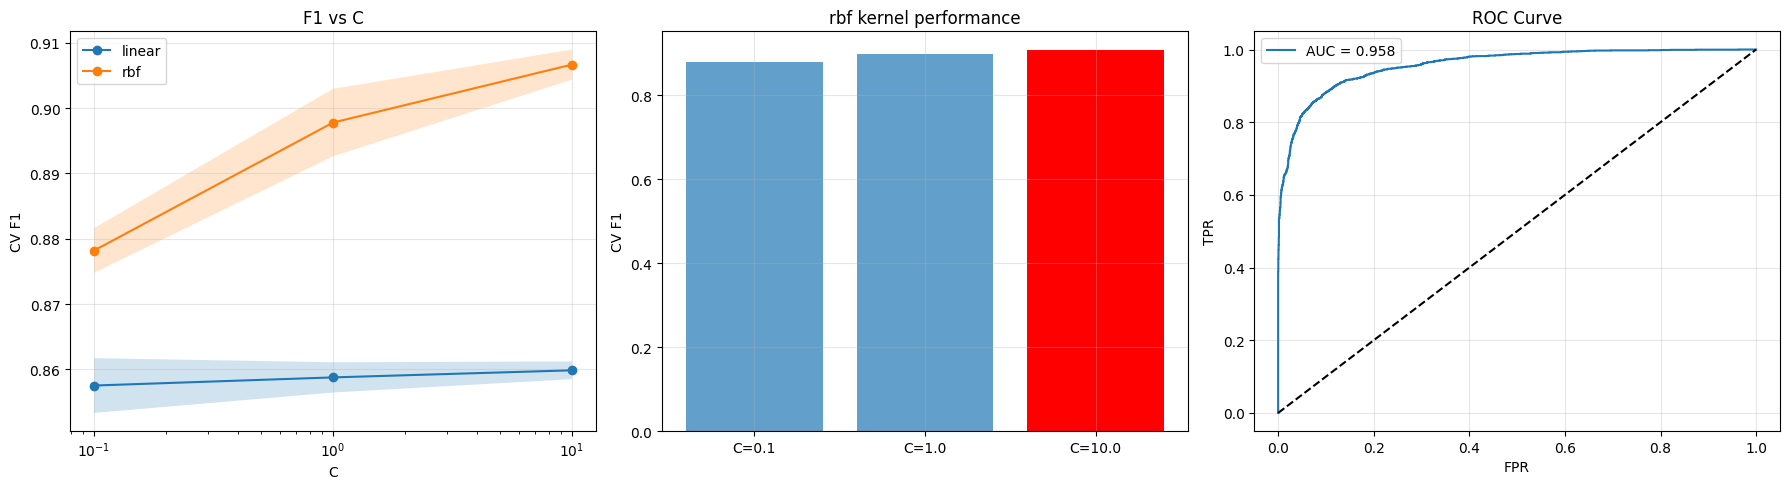

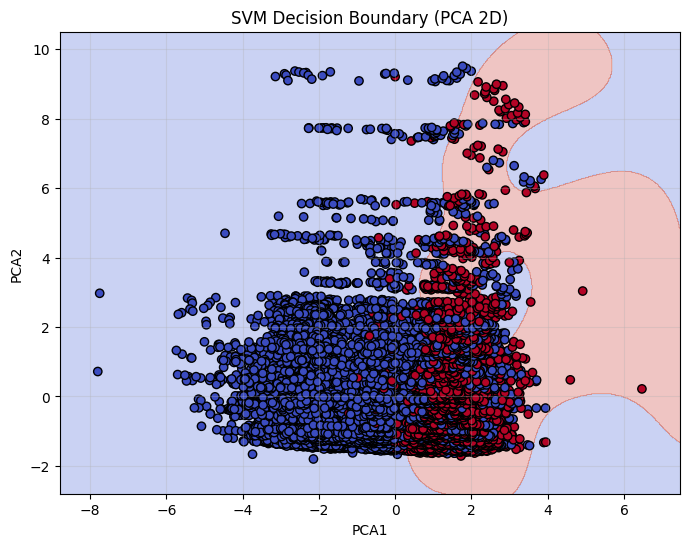

In [38]:
# SVM training and evaluation (linear and RBF with gamma='scale')

kernels = ['linear', 'rbf']
C_values = [0.1, 1.0, 10.0]
svm_results = []

print("Evaluating SVM configurations:")
for kernel in kernels:
    print(f"\nKernel: {kernel}")
    for C in C_values:
        if kernel == 'rbf':
            svm = SVC(C=C, kernel=kernel, gamma='scale', probability=True, random_state=42)
        else:
            svm = SVC(C=C, kernel=kernel, probability=True, random_state=42)
        
        scores = cross_val_score(svm, X_train_scaled, y_train, cv=3, scoring='f1_weighted')
        avg = scores.mean()
        std = scores.std()
        
        svm_results.append({
            'Kernel': kernel,
            'C': C,
            'CV_F1_Mean': avg,
            'CV_F1_Std': std
        })
        
        print(f"  C={C} -> F1={avg:.4f} (+/- {std*2:.4f})")

# Choosing best configuration
best_idx = max(range(len(svm_results)), key=lambda i: svm_results[i]['CV_F1_Mean'])
best_config = svm_results[best_idx]

print("\nBest configuration:")
print(f"Kernel = {best_config['Kernel']}, C = {best_config['C']}, F1 = {best_config['CV_F1_Mean']:.4f}")

# Train final model on full training set
if best_config['Kernel'] == 'rbf':
    svm_final = SVC(C=best_config['C'], kernel='rbf', gamma='scale', probability=True, random_state=42)
else:
    svm_final = SVC(C=best_config['C'], kernel='linear', probability=True, random_state=42)

svm_final.fit(X_train_scaled, y_train)

# Make predictions on test set
svm_pred = svm_final.predict(X_test_scaled)
svm_proba = svm_final.predict_proba(X_test_scaled)[:, 1]

# Evaluate test performance
acc = accuracy_score(y_test, svm_pred)
prec = precision_score(y_test, svm_pred, average='weighted')
rec = recall_score(y_test, svm_pred, average='weighted')
f1 = f1_score(y_test, svm_pred, average='weighted')
auc = roc_auc_score(y_test, svm_proba)

print("\nTest set performance:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"AUC:       {auc:.4f}")

# Plot results
svm_df = pd.DataFrame(svm_results)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# F1 vs C for each kernel
for kernel in kernels:
    kernel_data = svm_df[svm_df['Kernel'] == kernel]
    axes[0].plot(kernel_data['C'], kernel_data['CV_F1_Mean'], marker='o', label=kernel)
    axes[0].fill_between(kernel_data['C'],
                         kernel_data['CV_F1_Mean'] - kernel_data['CV_F1_Std'],
                         kernel_data['CV_F1_Mean'] + kernel_data['CV_F1_Std'],
                         alpha=0.2)
axes[0].set_xscale('log')
axes[0].set_xlabel('C')
axes[0].set_ylabel('CV F1')
axes[0].set_title('F1 vs C')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Bar chart for best kernel
best_kernel_data = svm_df[svm_df['Kernel'] == best_config['Kernel']]
axes[1].bar(range(len(C_values)), best_kernel_data['CV_F1_Mean'], alpha=0.7)
axes[1].set_xticks(range(len(C_values)))
axes[1].set_xticklabels([f'C={c}' for c in C_values])
axes[1].set_ylabel('CV F1')
axes[1].set_title(f'{best_config["Kernel"]} kernel performance')
axes[1].grid(True, alpha=0.3)
best_c_idx = C_values.index(best_config['C'])
axes[1].bar(best_c_idx, best_kernel_data.iloc[best_c_idx]['CV_F1_Mean'], color='red')

# ROC curve
fpr, tpr, _ = roc_curve(y_test, svm_proba)
axes[2].plot(fpr, tpr, label=f'AUC = {auc:.3f}')
axes[2].plot([0, 1], [0, 1], 'k--')
axes[2].set_xlabel('FPR')
axes[2].set_ylabel('TPR')
axes[2].set_title('ROC Curve')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# decision boundary plot--

from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC

pca = PCA(n_components=2)
X_vis = pca.fit_transform(X_train_scaled)
svm_vis = SVC(C=best_config['C'], kernel=best_config['Kernel'],
              gamma='scale' if best_config['Kernel'] == 'rbf' else 'auto')
svm_vis.fit(X_vis, y_train)
h = 0.02
x_min, x_max = X_vis[:, 0].min() - 1, X_vis[:, 0].max() + 1
y_min, y_max = X_vis[:, 1].min() - 1, X_vis[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = svm_vis.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
plt.scatter(X_vis[:, 0], X_vis[:, 1], c=y_train, edgecolors='k', cmap='coolwarm')
plt.title("SVM Decision Boundary (PCA 2D)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.grid(True, alpha=0.3)
plt.show()


## Decision Trees and Ensemble Methods
**Decision Trees**: Rule-based hierarchical classification with interpretable if-then rules
**Ensemble Methods**: Combine multiple models to improve prediction accuracy and robustness
- **Random Forest**: Bootstrap aggregating with random feature selection
- **Gradient Boosting**: Sequential learning from previous model errors

**Optimization**: Grid search for individual trees, default parameters for ensembles for comparison

In [39]:
# Decision Tree Optimization
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'criterion': ['entropy']
}

# Create and optimize Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(dt_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

print("Best Decision Tree Parameters: {}".format(grid_search.best_params_))
dt_best = grid_search.best_estimator_

# Decision Tree Evaluation
dt_predictions = dt_best.predict(X_test_scaled)
dt_probabilities = dt_best.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
dt_accuracy = accuracy_score(y_test, dt_predictions)
dt_precision = precision_score(y_test, dt_predictions)
dt_recall = recall_score(y_test, dt_predictions)
dt_f1 = f1_score(y_test, dt_predictions)
dt_auc = roc_auc_score(y_test, dt_probabilities)

print("Decision Tree Performance:")
print(f"Accuracy:  {dt_accuracy:.4f}")
print(f"Precision: {dt_precision:.4f}")
print(f"Recall:    {dt_recall:.4f}")
print(f"F1-Score:  {dt_f1:.4f}")
print(f"AUC:       {dt_auc:.4f}")
print(classification_report(y_test, dt_predictions))

Best Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2}
Decision Tree Performance:
Accuracy:  0.9313
Precision: 0.9899
Recall:    0.8447
F1-Score:  0.9116
AUC:       0.9555
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      2897
           1       0.99      0.84      0.91      2093

    accuracy                           0.93      4990
   macro avg       0.94      0.92      0.93      4990
weighted avg       0.94      0.93      0.93      4990



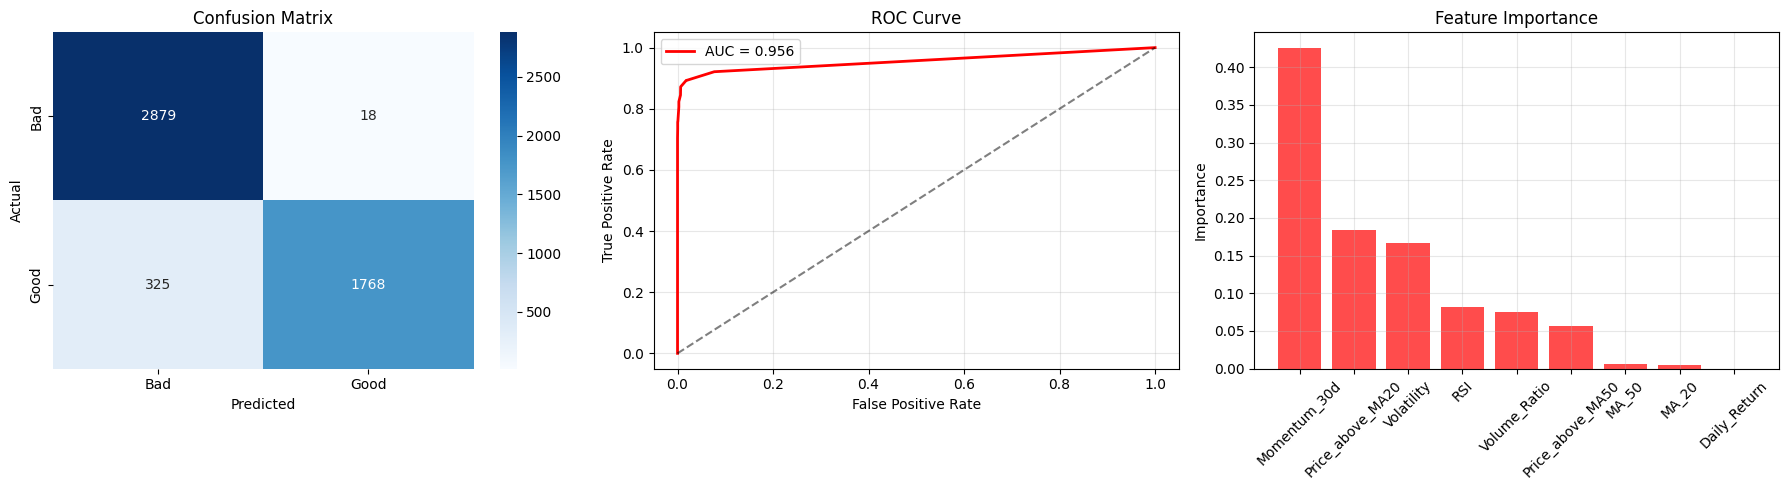

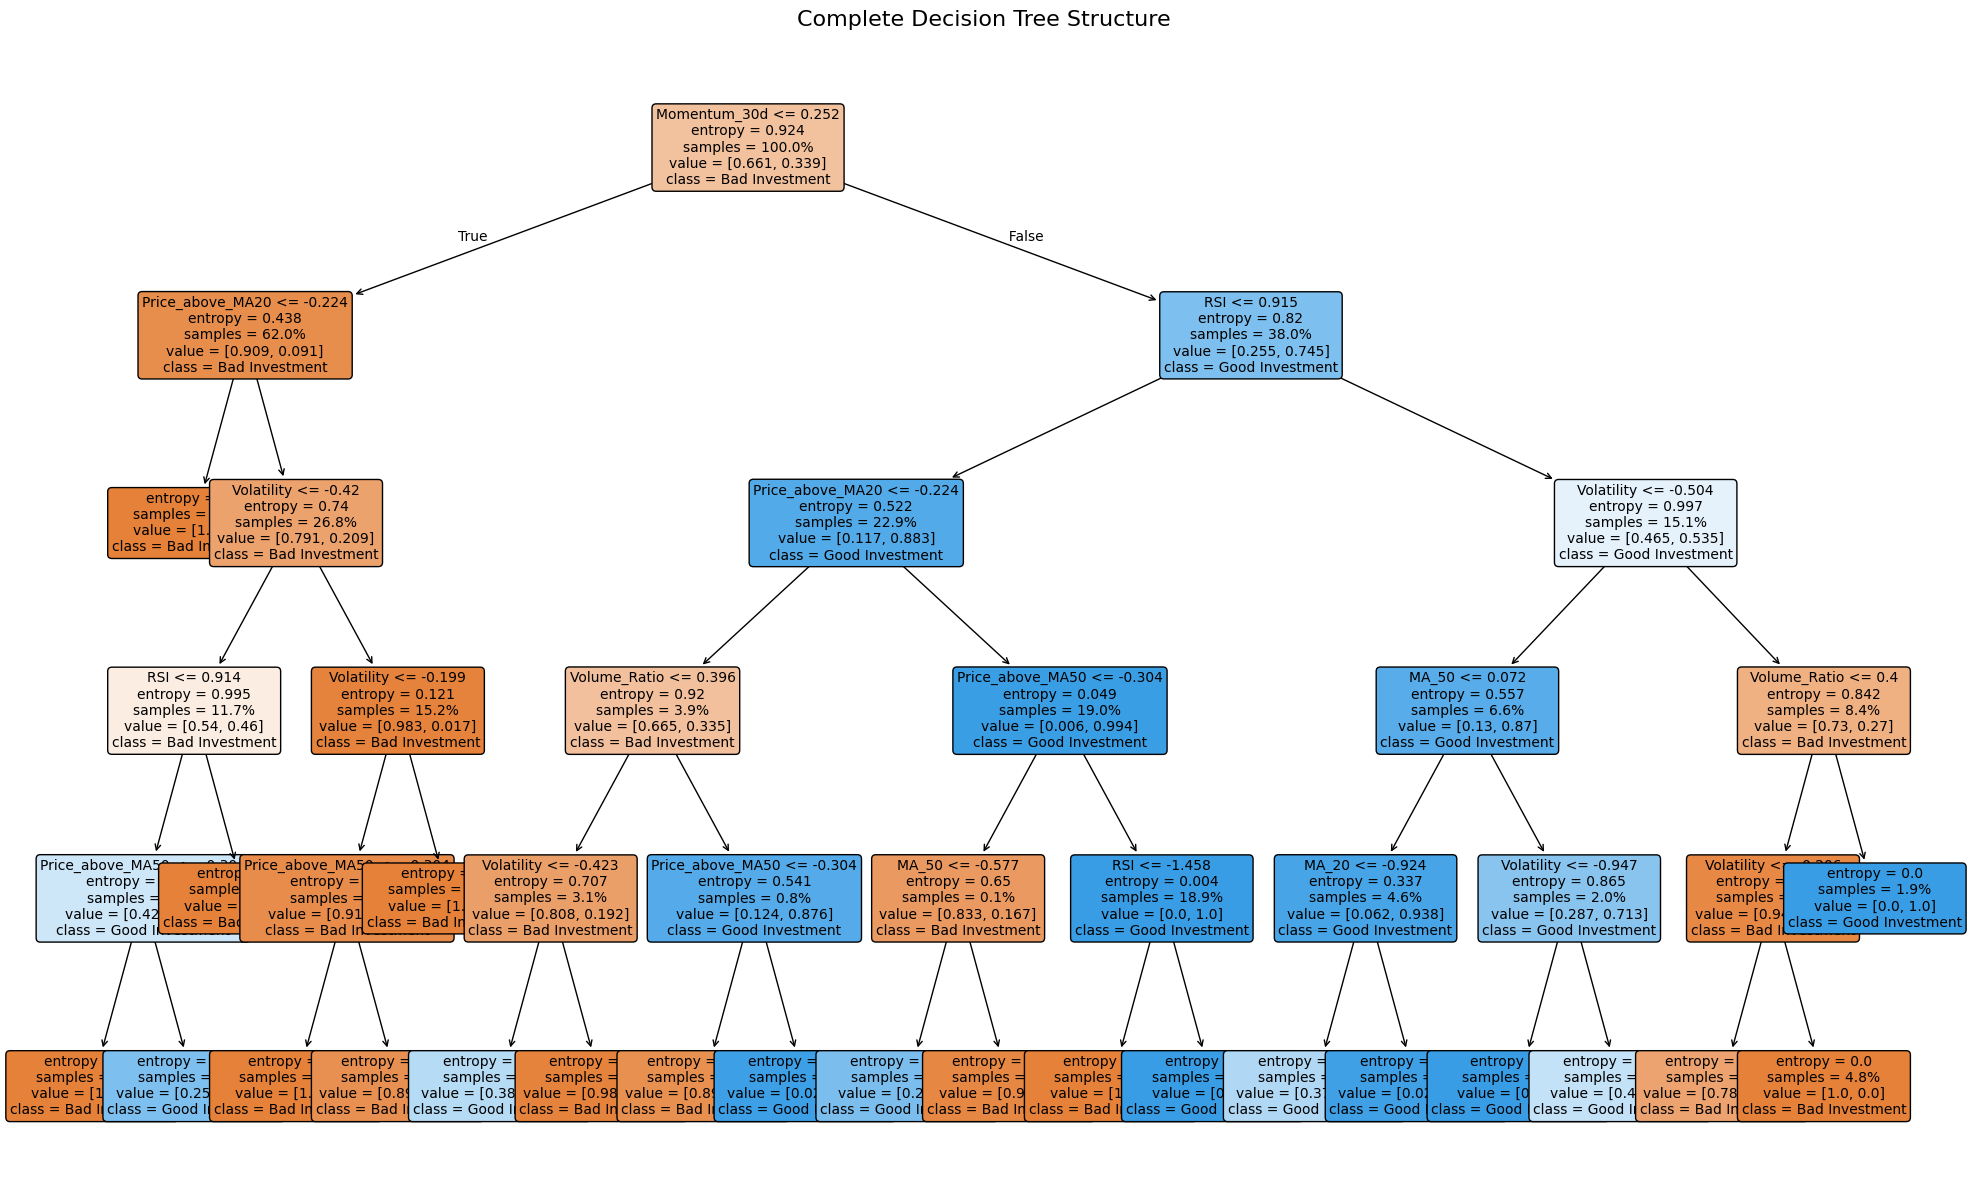

In [40]:
# Decision Tree Visualizations
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

#Confusion Matrix
cm = confusion_matrix(y_test, dt_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Bad', 'Good'], yticklabels=['Bad', 'Good'])
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, dt_probabilities)
axes[1].plot(fpr, tpr, label=f'AUC = {dt_auc:.3f}', color='red', linewidth=2)
axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Feature Importance
feature_importance = dt_best.feature_importances_
indices = np.argsort(feature_importance)[::-1]
axes[2].bar(range(len(feature_importance)), feature_importance[indices], 
            alpha=0.7, color='red')
axes[2].set_xticks(range(len(feature_importance)))
axes[2].set_xticklabels([feature_cols[i] for i in indices], rotation=45)
axes[2].set_ylabel('Importance')
axes[2].set_title('Feature Importance')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# # Visualize the Decision Tree
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 12))
plot_tree(dt_best, 
          feature_names=feature_cols, 
          class_names=['Bad Investment', 'Good Investment'], 
          filled=True, 
          fontsize=10,
          proportion=True,
          impurity=True,
          rounded=True)
plt.title('Complete Decision Tree Structure', fontsize=16, pad=20)
plt.tight_layout()
plt.show()



### Ensemble Methods - Random Forest

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Random Forest Parameters: {'max_depth': 10, 'n_estimators': 51}
Random Forest Performance:
Accuracy: 0.9246
Precision: 0.9977
Recall: 0.8223
F1-Score: 0.9015
AUC-ROC: 0.9657
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      2897
           1       1.00      0.82      0.90      2093

    accuracy                           0.92      4990
   macro avg       0.94      0.91      0.92      4990
weighted avg       0.93      0.92      0.92      4990



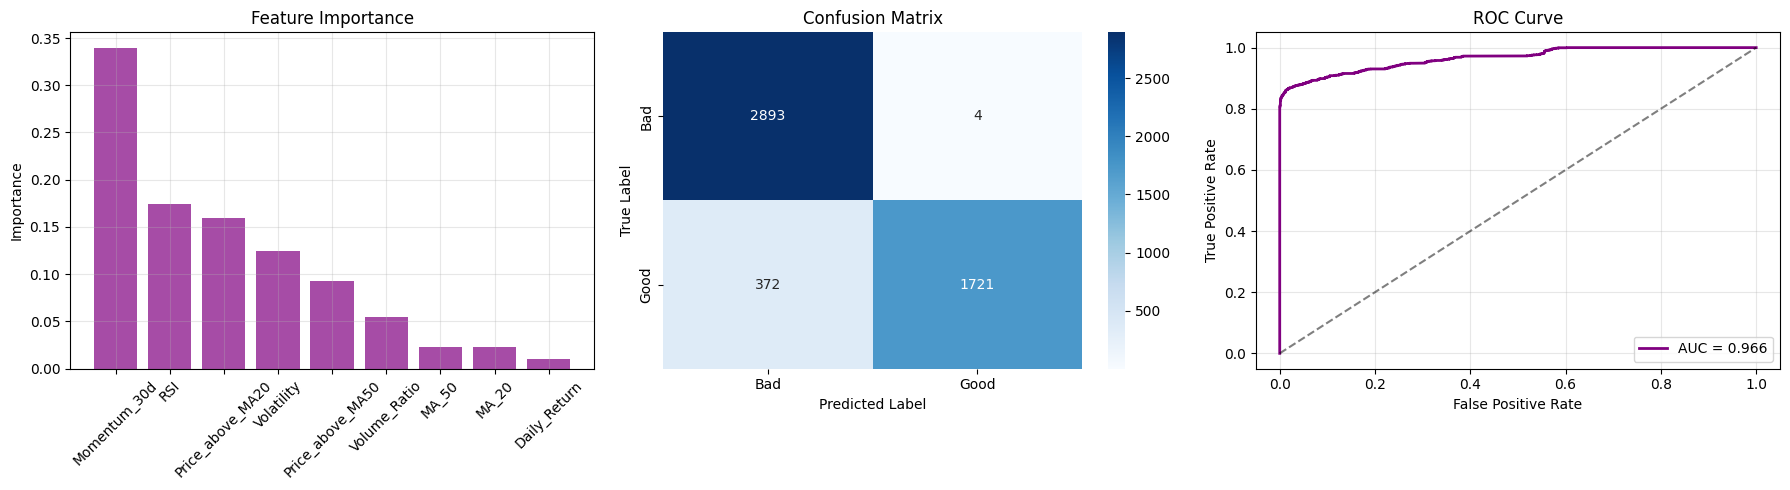

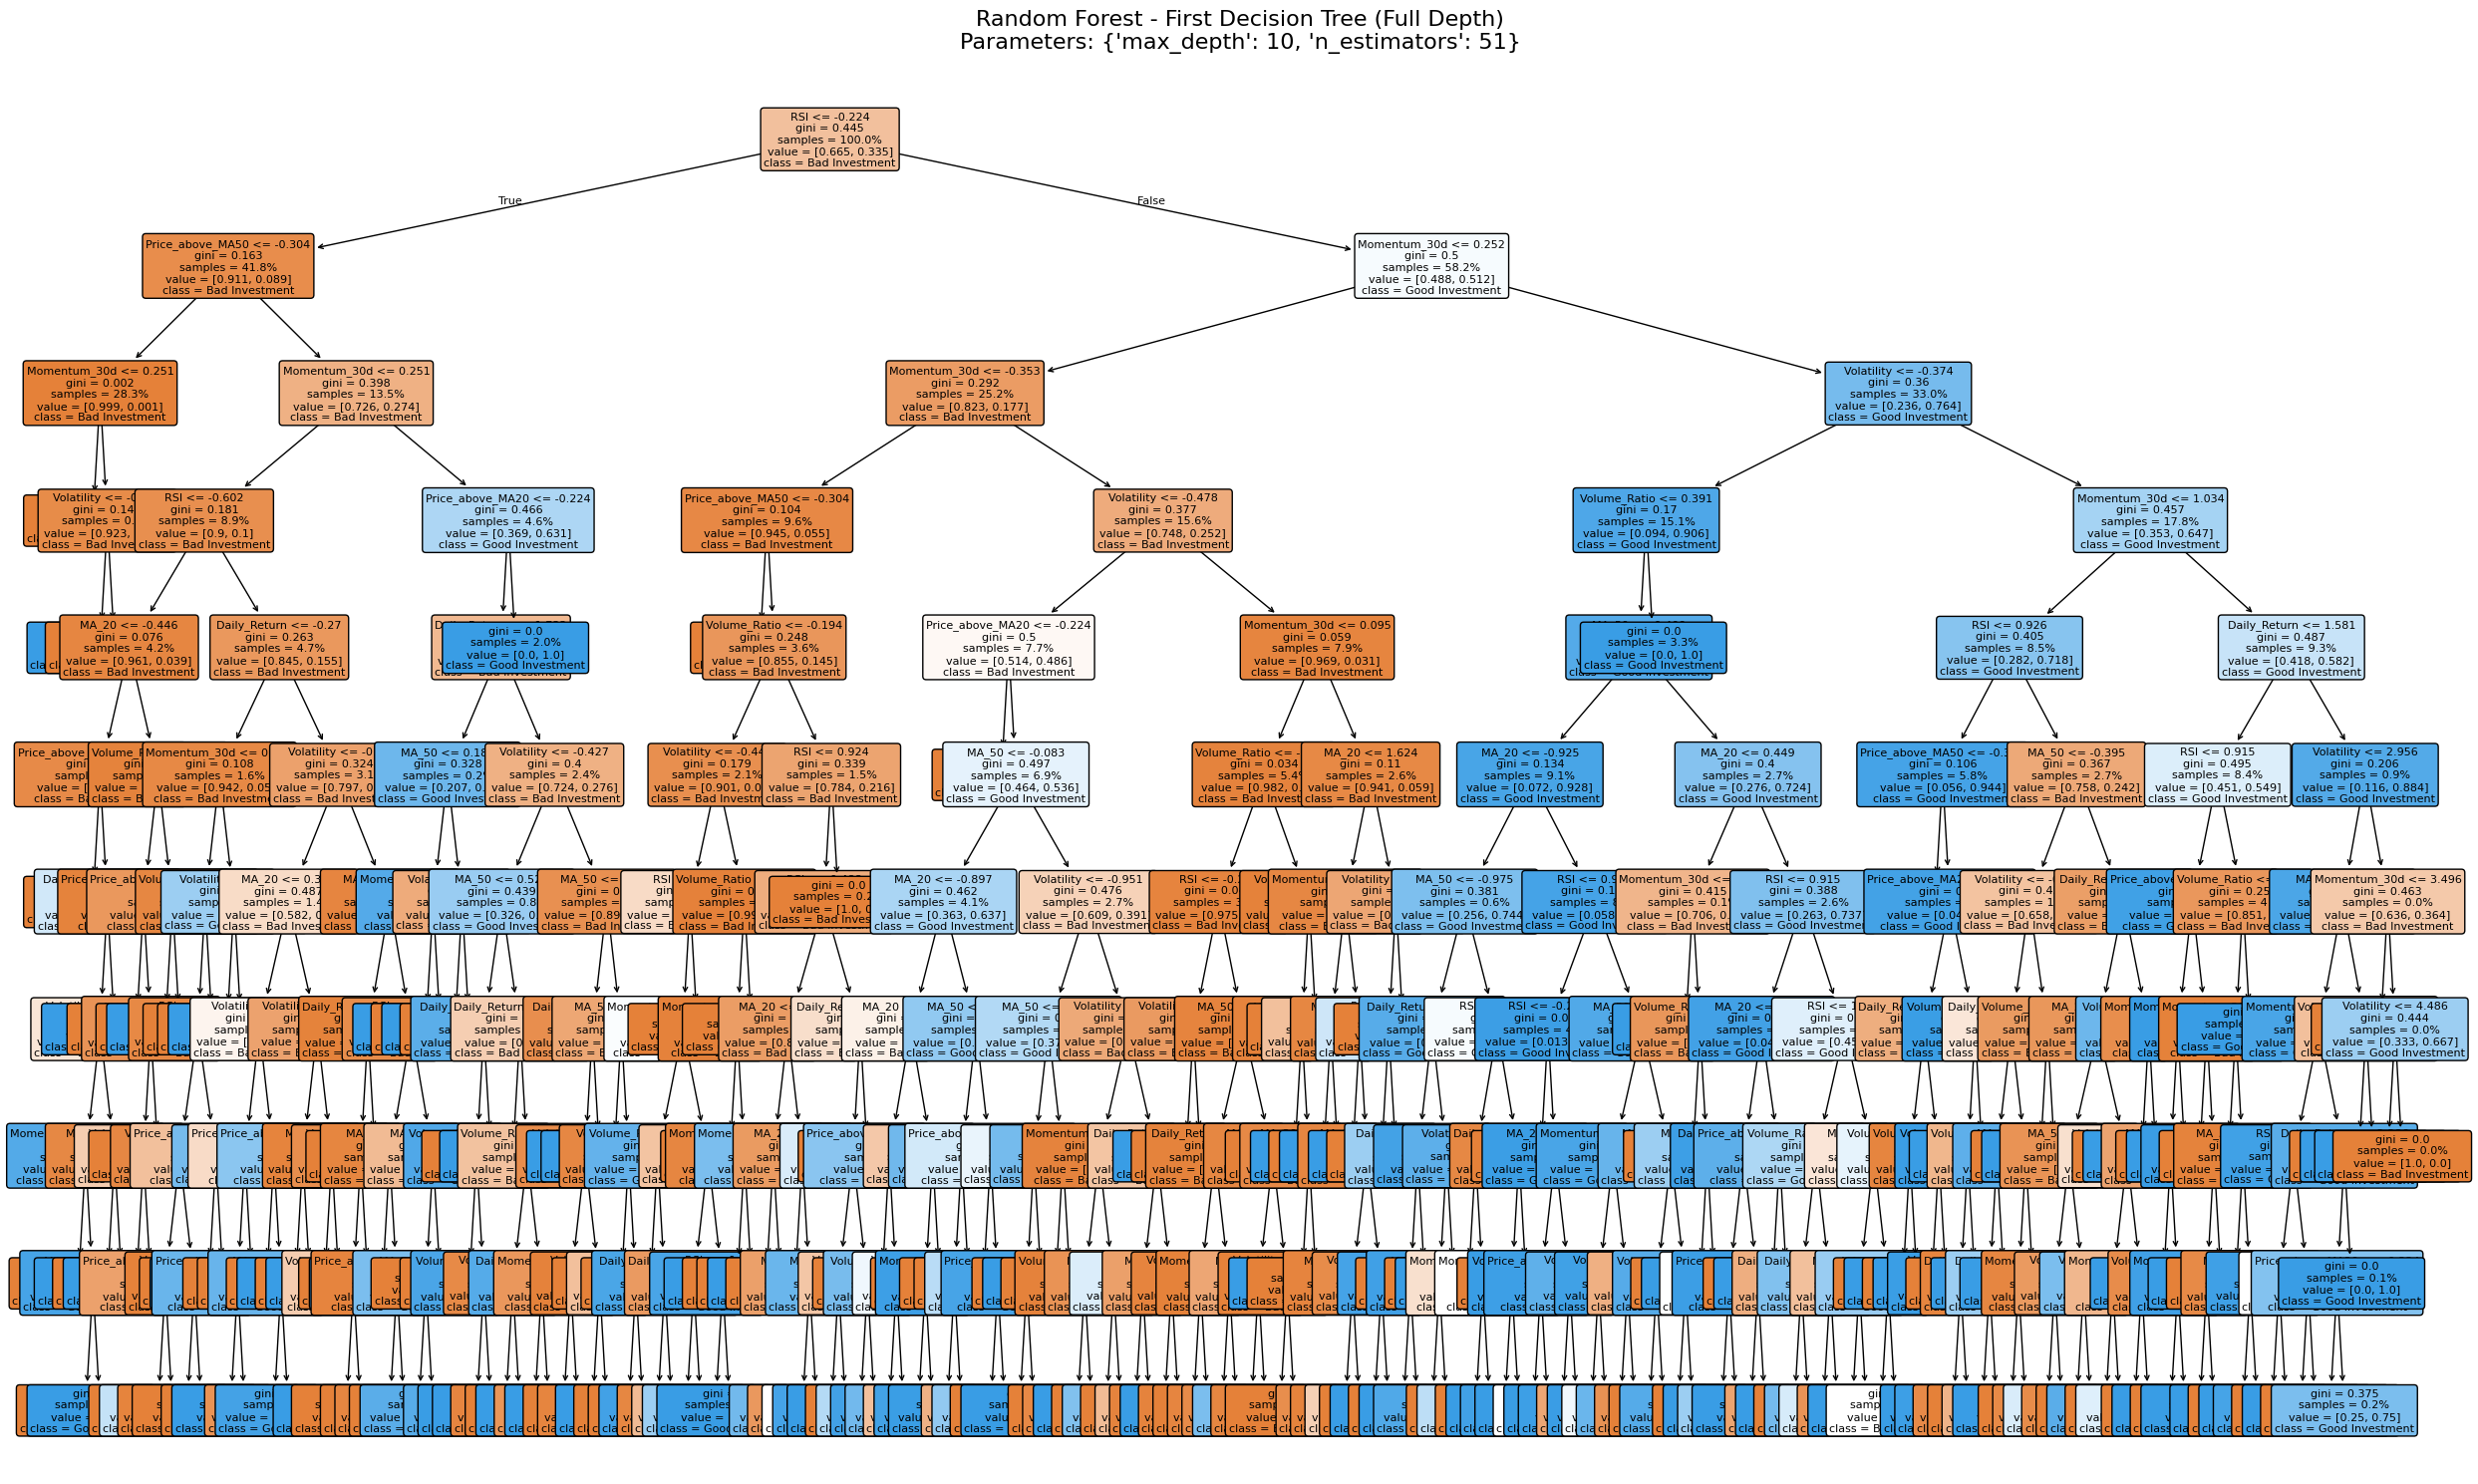

Random Forest Tree Statistics:
Number of trees: 51
Tree depth (first tree): 10
Number of leaves (first tree): 238
Number of nodes (first tree): 475


In [41]:
# Random Forest with Grid Search
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Create Random Forest model
randomforest_model = RandomForestClassifier(random_state=42)

# Define hyperparameters to be optimized
param_grid_rf = {
    'n_estimators': [51, 101, 201],
    'max_depth': [3, 5, 10]
}

# Run Grid Search to find the best hyperparameters
grid_search_rf = GridSearchCV(
    estimator=randomforest_model, 
    param_grid=param_grid_rf, 
    cv=5, 
    scoring='accuracy', 
    verbose=1
)
grid_search_rf.fit(X_train_scaled, y_train)

# Get best parameters and model
print('Best Random Forest Parameters: {}'.format(grid_search_rf.best_params_))
best_randomforest_model = grid_search_rf.best_estimator_

# Make predictions on test set
rf_predictions = best_randomforest_model.predict(X_test_scaled)
rf_probabilities = best_randomforest_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate Random Forest
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_precision = precision_score(y_test, rf_predictions)
rf_recall = recall_score(y_test, rf_predictions)
rf_f1 = f1_score(y_test, rf_predictions)
rf_auc = roc_auc_score(y_test, rf_probabilities)

print("Random Forest Performance:")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall: {rf_recall:.4f}")
print(f"F1-Score: {rf_f1:.4f}")
print(f"AUC-ROC: {rf_auc:.4f}")
print(classification_report(y_test, rf_predictions))

# Random Forest Visualizations
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Feature Importance
rf_importance = best_randomforest_model.feature_importances_
indices = np.argsort(rf_importance)[::-1]
axes[0].bar(range(len(rf_importance)), rf_importance[indices], 
            alpha=0.7, color='purple')
axes[0].set_xticks(range(len(rf_importance)))
axes[0].set_xticklabels([feature_cols[i] for i in indices], rotation=45)
axes[0].set_ylabel('Importance')
axes[0].set_title('Feature Importance')
axes[0].grid(True, alpha=0.3)

# Confusion Matrix
cm_rf = confusion_matrix(y_test, rf_predictions)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['Bad', 'Good'], yticklabels=['Bad', 'Good'])
axes[1].set_title('Confusion Matrix')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

# ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probabilities)
axes[2].plot(fpr_rf, tpr_rf, color='purple', linewidth=2, 
             label=f'AUC = {rf_auc:.3f}')
axes[2].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[2].set_xlabel('False Positive Rate')
axes[2].set_ylabel('True Positive Rate')
axes[2].set_title('ROC Curve')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Visualize Random Forest Tree Structure (first tree in detail)

# Get the first tree from the Random Forest
first_tree = best_randomforest_model.estimators_[0]

plt.figure(figsize=(25, 15))
plot_tree(first_tree, 
          feature_names=feature_cols, 
          class_names=['Bad Investment', 'Good Investment'], 
          filled=True, 
          fontsize=8,
          proportion=True,
          impurity=True,
          rounded=True,
          max_depth=None)
plt.title(f'Random Forest - First Decision Tree (Full Depth)\nParameters: {grid_search_rf.best_params_}', 
          fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# Also show tree statistics
print(f"Random Forest Tree Statistics:")
print(f"Number of trees: {best_randomforest_model.n_estimators}")
print(f"Tree depth (first tree): {first_tree.get_depth()}")
print(f"Number of leaves (first tree): {first_tree.get_n_leaves()}")
print(f"Number of nodes (first tree): {first_tree.tree_.node_count}")



### Ensemble Methods - XGBoost

XGBOOST OPTIMIZATION:
Best Parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 51}
XGBoost Performance:
Accuracy: 0.9253
Precision: 0.9960
Recall: 0.8251
F1-Score: 0.9025
AUC-ROC: 0.9828
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      2897
           1       1.00      0.83      0.90      2093

    accuracy                           0.93      4990
   macro avg       0.94      0.91      0.92      4990
weighted avg       0.93      0.93      0.92      4990



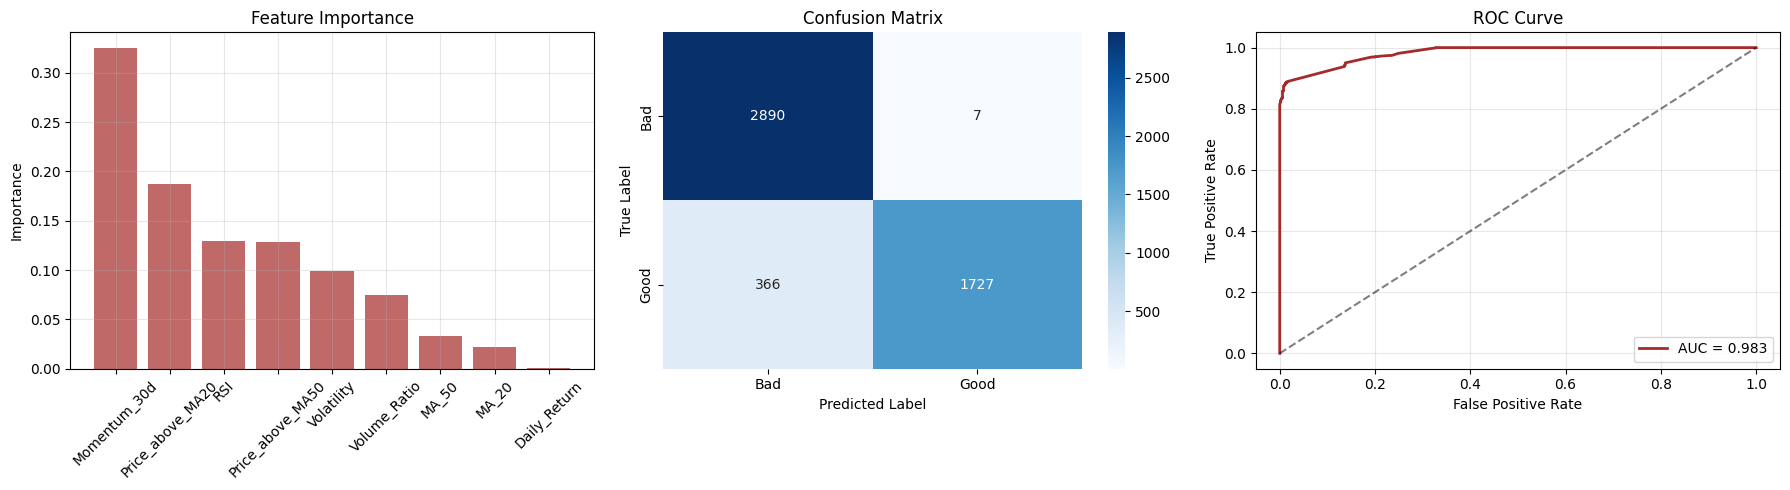

In [42]:
# XGBoost with Grid Search
#!pip install graphviz
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report, roc_curve)
from sklearn.model_selection import GridSearchCV
from xgboost import plot_tree

# Create XGBoost model
xgboost_model = XGBClassifier(eval_metric='logloss', random_state=42)

# Define parameters to optimize
param_grid_xgb = {
    'n_estimators': [51, 101, 201],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Run Grid Search to find the best hyperparameters
print("XGBOOST OPTIMIZATION:")
grid_search_xgboost = GridSearchCV(
    estimator=xgboost_model, 
    param_grid=param_grid_xgb, 
    cv=5, 
    scoring='accuracy'
)
grid_search_xgboost.fit(X_train_scaled, y_train)

# Get best parameters and model
print("Best Parameters for XGBoost: {}".format(grid_search_xgboost.best_params_))
best_xgboost_model = grid_search_xgboost.best_estimator_

# Make predictions on test set
xgb_predictions = best_xgboost_model.predict(X_test_scaled)
xgb_probabilities = best_xgboost_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate XGBoost
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
xgb_precision = precision_score(y_test, xgb_predictions)
xgb_recall = recall_score(y_test, xgb_predictions)
xgb_f1 = f1_score(y_test, xgb_predictions)
xgb_auc = roc_auc_score(y_test, xgb_probabilities)

print("XGBoost Performance:")
print(f"Accuracy: {xgb_accuracy:.4f}")
print(f"Precision: {xgb_precision:.4f}")
print(f"Recall: {xgb_recall:.4f}")
print(f"F1-Score: {xgb_f1:.4f}")
print(f"AUC-ROC: {xgb_auc:.4f}")
print(classification_report(y_test, xgb_predictions))

# XGBoost Visualizations
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Feature Importance
xgb_importance = best_xgboost_model.feature_importances_
indices = np.argsort(xgb_importance)[::-1]
axes[0].bar(range(len(xgb_importance)), xgb_importance[indices], 
            alpha=0.7, color='brown')
axes[0].set_xticks(range(len(xgb_importance)))
axes[0].set_xticklabels([feature_cols[i] for i in indices], rotation=45)
axes[0].set_ylabel('Importance')
axes[0].set_title('Feature Importance')
axes[0].grid(True, alpha=0.3)

# Confusion Matrix
cm_xgb = confusion_matrix(y_test, xgb_predictions)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['Bad', 'Good'], yticklabels=['Bad', 'Good'])
axes[1].set_title('Confusion Matrix')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

# ROC Curve
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_probabilities)
axes[2].plot(fpr_xgb, tpr_xgb, color='brown', linewidth=2, 
             label=f'AUC = {xgb_auc:.3f}')
axes[2].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[2].set_xlabel('False Positive Rate')
axes[2].set_ylabel('True Positive Rate')
axes[2].set_title('ROC Curve')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# # Visualize XGBoost Tree Structure
# import matplotlib.pyplot as plt

# # Plot the first tree from XGBoost with full depth
# plt.figure(figsize=(25, 15))
# plot_tree(best_xgboost_model, num_trees=0, rankdir='TB', ax=plt.gca())
# plt.title(f'XGBoost - First Decision Tree (Full Depth)\nParameters: {grid_search_xgboost.best_params_}', 
#           fontsize=16, pad=20)
# plt.tight_layout()
# plt.show()

# # Display tree statistics
# print(f"XGBoost Model Statistics:")
# print(f"Number of trees: {best_xgboost_model.n_estimators}")
# print(f"Learning rate: {best_xgboost_model.learning_rate}")
# print(f"Max depth: {best_xgboost_model.max_depth}")


# Model Evaluation Results

FINAL MODEL PERFORMANCE COMPARISON:
              Model  Accuracy  Precision  Recall  F1-Score    AUC
      Decision Tree    0.9313     0.9899  0.8447    0.9116 0.9555
            XGBoost    0.9253     0.9960  0.8251    0.9025 0.9828
      Random Forest    0.9246     0.9977  0.8223    0.9015 0.9657
                SVM    0.8770     0.8867  0.8770    0.8740 0.9579
                KNN    0.8685     0.8772  0.8685    0.8655 0.9334
Logistic Regression    0.8421     0.8432  0.8421    0.8402 0.9253

Best Model: Decision Tree (F1-Score: 0.9116)


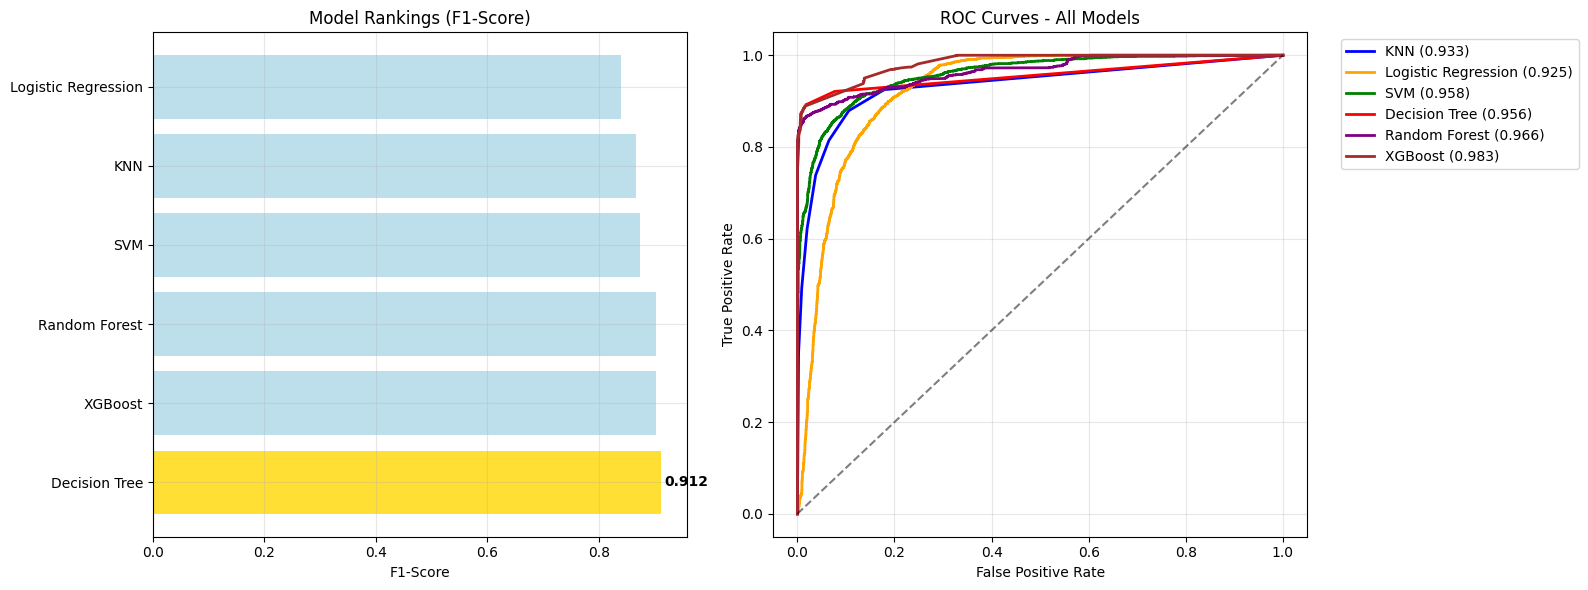

In [43]:
# Final Model Comparison
print("FINAL MODEL PERFORMANCE COMPARISON:")

all_results = {
    'Model': ['KNN', 'Logistic Regression', 'SVM', 'Decision Tree', 'Random Forest', 'XGBoost'],
    'Accuracy': [knn_metrics['Accuracy'], lr_metrics['Accuracy'], acc, 
                 dt_accuracy, rf_accuracy, xgb_accuracy],
    'Precision': [knn_metrics['Precision'], lr_metrics['Precision'], prec, 
                  dt_precision, rf_precision, xgb_precision],
    'Recall': [knn_metrics['Recall'], lr_metrics['Recall'], rec, 
               dt_recall, rf_recall, xgb_recall],
    'F1-Score': [knn_metrics['F1-Score'], lr_metrics['F1-Score'], f1, 
                 dt_f1, rf_f1, xgb_f1],
    'AUC': [knn_metrics['AUC'], lr_metrics['AUC'], auc, 
            dt_auc, rf_auc, xgb_auc]
}

results_df = pd.DataFrame(all_results).round(4)
results_sorted = results_df.sort_values('F1-Score', ascending=False)
print(results_sorted.to_string(index=False))

best_model = results_sorted.iloc[0]['Model']
best_f1 = results_sorted.iloc[0]['F1-Score']
print(f"\nBest Model: {best_model} (F1-Score: {best_f1:.4f})")

# Final Comparison Visualizations
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Model Rankings by F1-Score
model_names = results_sorted['Model'].values
f1_scores = results_sorted['F1-Score'].values
colors = ['gold' if i == 0 else 'lightblue' for i in range(len(model_names))]

axes[0].barh(range(len(model_names)), f1_scores, color=colors, alpha=0.8)
axes[0].set_yticks(range(len(model_names)))
axes[0].set_yticklabels(model_names)
axes[0].set_xlabel('F1-Score')
axes[0].set_title('Model Rankings (F1-Score)')
axes[0].grid(True, alpha=0.3)
axes[0].text(f1_scores[0] + 0.005, 0, f'{f1_scores[0]:.3f}', va='center', fontweight='bold')

# ROC Curves Comparison
model_probabilities = [knn_proba, lr_proba, svm_proba, dt_probabilities, rf_probabilities, xgb_probabilities]
model_colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']

for i, (name, proba, color) in enumerate(zip(all_results['Model'], model_probabilities, model_colors)):
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc_score = all_results['AUC'][i]
    axes[1].plot(fpr, tpr, label=f'{name} ({auc_score:.3f})', 
                color=color, linewidth=2)

axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curves - All Models')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [44]:
# Model Performance Evaluation
models_eval = {
    'KNN': (knn_pred, knn_proba),
    'Logistic Regression': (lr_pred, lr_proba),
    'SVM': (svm_pred, svm_proba),
    'Decision Tree': (dt_predictions, dt_probabilities),
    'Random Forest': (rf_predictions, rf_probabilities),
    'XGBoost': (xgb_predictions, xgb_probabilities)
}

results = []
for name, (pred, proba) in models_eval.items():
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, pred),
        'Precision': precision_score(y_test, pred),
        'Recall': recall_score(y_test, pred),
        'F1-Score': f1_score(y_test, pred),
        'AUC': roc_auc_score(y_test, proba)
    })

final_results = pd.DataFrame(results).round(4)
print("FINAL MODEL RANKINGS: ")
print(final_results.sort_values('F1-Score', ascending=False).to_string(index=False))

best_model = final_results.loc[final_results['F1-Score'].idxmax(), 'Model']
best_f1 = final_results['F1-Score'].max()
print(f"\n Winner: {best_model} (F1-Score: {best_f1:.4f})")

# Best Model Analysis
print(f"BEST MODEL ANALYSIS: {best_model}")
print(f"F1-Score: {best_f1:.4f}")
print(f"Accuracy: {results_sorted.iloc[0]['Accuracy']:.4f}")
print(f"AUC: {results_sorted.iloc[0]['AUC']:.4f}")

# Get best model predictions for classification report
if best_model == 'KNN':
    best_predictions = knn_pred
elif best_model == 'Logistic Regression':
    best_predictions = lr_pred
elif best_model == 'SVM':
    best_predictions = svm_pred
elif best_model == 'Decision Tree':
    best_predictions = dt_predictions
elif best_model == 'Random Forest':
    best_predictions = rf_predictions
else:  # XGBoost
    best_predictions = xgb_predictions

print(f"\nClassification Report - {best_model}:")
print(classification_report(y_test, best_predictions, target_names=['Bad Investment', 'Good Investment']))

FINAL MODEL RANKINGS: 
              Model  Accuracy  Precision  Recall  F1-Score    AUC
      Decision Tree    0.9313     0.9899  0.8447    0.9116 0.9555
            XGBoost    0.9253     0.9960  0.8251    0.9025 0.9828
      Random Forest    0.9246     0.9977  0.8223    0.9015 0.9657
                SVM    0.8770     0.9495  0.7463    0.8357 0.9579
                KNN    0.8685     0.9341  0.7387    0.8250 0.9334
Logistic Regression    0.8421     0.8560  0.7496    0.7993 0.9253

 Winner: Decision Tree (F1-Score: 0.9116)
BEST MODEL ANALYSIS: Decision Tree
F1-Score: 0.9116
Accuracy: 0.9313
AUC: 0.9555

Classification Report - Decision Tree:
                 precision    recall  f1-score   support

 Bad Investment       0.90      0.99      0.94      2897
Good Investment       0.99      0.84      0.91      2093

       accuracy                           0.93      4990
      macro avg       0.94      0.92      0.93      4990
   weighted avg       0.94      0.93      0.93      4990

